In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
from templates import TEMPLATES

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Image,display

In [3]:
# Create widgets
directory = widgets.Dropdown(options=['baseball', 'checkerboard'])
images = widgets.Dropdown(options=os.listdir('data/'+directory.value))
input_img_variable=widgets.Text()

# Updates the image options based on directory value
def update_images(*args):
    images.options = sorted(os.listdir('data/'+directory.value))

# Tie the image options to directory value
directory.observe(update_images, 'value')

# Show the images
def select_image(template, file):
    display(Image('data/'+template+'/'+file))
    f = open('data/'+template+'/'+file, "rb")
    input_img_variable.value='data/'+template+'/'+file
    return

_ = interact(select_image, template=directory, file=images)

interactive(children=(Dropdown(description='template', options=('baseball', 'checkerboard'), value='baseball')…

In [4]:
image_path=input_img_variable.value
input_img=cv2.imread(image_path)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [5]:
obj_widget_width = widgets.Text()
obj_widget_height = widgets.Text()

In [6]:
def inputObjpoints(width,height):
    if width.isdigit():
        obj_widget_width.value=width
        obj_widget_height.value=height
    return

In [7]:
widths=[str(x+1) for x in range(6)]
heights=[str(x+1) for x in range(7)]
obj_widget=interact(inputObjpoints, width=widths,height=heights);

interactive(children=(Dropdown(description='width', options=('1', '2', '3', '4', '5', '6'), value='1'), Dropdo…

In [8]:
w = int(obj_widget_width.value)
h=int(obj_widget_height.value)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((w*h,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)

In [9]:
def inputImgpoints(img,auto=True):
    ret,corners2=False,None
    if auto:
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, (7,6),None)

        if ret == True:
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    return ret,corners2


In [10]:
def matchObjImg(img,objp,imgp,auto=True):
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    if auto:
        objpoints.append(objp)
        imgpoints.append(imgp)
    objpoints=np.array(objpoints).reshape(1,-1,3).astype('float32')
    imgpoints=np.array(imgpoints).reshape(1,-1,2).astype('float32')
        
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (7,6), imgp,ret)
    cv2.imshow('image',img)
    cv2.waitKey(2000)

    cv2.destroyAllWindows()
    return objpoints,imgpoints

In [11]:
def calibration(img,objpoints,imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    h,  w = img.shape[:2]
    newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    
    dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    cv2.imshow('output',dst) 
    cv2.waitKey(2000)

    cv2.destroyAllWindows()
    return dst,mtx,dist,rvecs,tvecs

In [13]:
ret,imgp=inputImgpoints(input_img)
if ret:
    objpoints,imgpoints=matchObjImg(input_img,objp,imgp)
    dst,mtx,dist,rvecs,tvecs=calibration(input_img,objpoints,imgpoints)

In [17]:
def drawProjection(matrix,objpoints,imgpoints,img):
    mtx,dist,rvecs,tvecs=matrix
    plt.imshow(img,cmap='gray', vmin=0, vmax=255)
    imgpoints2, _ = cv2.projectPoints(objpoints, rvecs[0], tvecs[0], mtx, dist)
    imgpoints2=np.array(imgpoints2).reshape(-1,2)
    error = cv2.norm(imgpoints,imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    for imgp,imgp2 in zip(imgpoints,imgpoints2.tolist()):
        ox,oy=imgp
        px,py=imgp2
        plt.scatter(x=ox, y=oy, c='r', s=10)  # original:red
        plt.scatter(x=px, y=py, c='y', s=10)  # calibration:yellow
    plt.show()
    return error

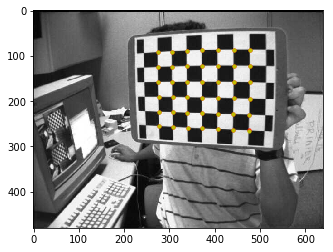

0.022552185443330906


In [18]:
import matplotlib.pyplot as plt

matrix=mtx,dist,rvecs,tvecs
img=plt.imread(image_path)
plt.imshow(img,'gray')
error=drawProjection(matrix,objpoints[0],imgpoints[0],img)
print(error)